# Comparing the German Constitutional Debt Brake and the EU Fiscal Rules

This file compares implications of the new EU fiscal framework with those of the German constitutional debt brake.

In [200]:
# Set autoreleoad
%load_ext autoreload
%autoreload 2

# Import libraries and modules
import sys
import os
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.3f}".format
pd.options.display.max_columns = None
pd.options.display.max_rows = 100
import matplotlib.pyplot as plt
plt.rcParams.update({'axes.grid':True, 'grid.color':'black','grid.alpha':'0.2','grid.linestyle':'-'})
plt.rcParams.update({'font.size': 14})

# Import DSA model class and stochastic subclass
sys.path.append(os.path.abspath('..'))
from classes import StochasticDsaModel as DSA
from functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Compare implications for a 4-year adjustment period

In [201]:
# Implications of the EU fiscal rules under November 2024 forecasts
model = DSA(country='DEU', adjustment_period=4)
model.find_spb_binding()

                  Model Params                              SPB Targets        
================================================     ==========================
country                                      DEU     main_adjustment      0.206
adjustment period                              4     lower_spb            0.619
adjustment start                            2025     financial_stress     0.246
shock frequency                        quarterly     adverse_r_g          0.604
stochastic period                      2029-2034     deficit_reduction   -0.469
estimation                                normal     stochastic         -10.557
bond level data                            False     debt_safeguard       0.764
safeguards         EDP, debt, deficit_resilience     binding              0.764
================================================     ==========================

                                 Binding Params                                
spb_steps                              

In [202]:
# Save EU results
eu_spb_target = model.spb_target
eu_results = model.df('sb', 'ob', 'ngdp').reset_index().loc[2:5]

In [203]:
# Calculate implications of enforced constiutional debt break
def calc_debt_break(model, bounds=[-3,3]):
    """
    Find SPB path consistent with a 0.35 percent structural deficit
    """

    model.project()
    adj_year = 0 

    # If sb is less then -0.35, increase by 0.001
    while (model.sb[model.adjustment_start + adj_year] < -0.35 and adj_year < model.adjustment_period):
    
        # Initiate spb step at lower bound increase by 0.001
        model.spb_steps[adj_year] += 0.001

        # Project using new steps
        model.project(
            spb_steps=model.spb_steps,
        )

        # If sb is -0.35, move to next period
        if model.sb[model.adjustment_start + adj_year] >= -0.35:
            adj_year += 1

# Apply debt break optimizer to dsa model
calc_debt_break(model)

In [204]:
# Save constitutional debt break results
db_spb_target = model.spb_target
db_results = model.df('sb', 'ob', 'ngdp').reset_index().loc[2:5]

In [205]:
# Compare results
def comp_results(eu_results, db_results):
    """
    Compare EU fiscal rule and debt break results
    """

    # Merge results
    results = eu_results.merge(db_results, on='y', suffixes=('_eu', '_db'))

    # Calculate differences
    for col in ['sb_eu', 'sb_db', 'ob_eu', 'ob_db']:
        results[col] = results[col] * -1
    results['sb_diff'] = results['sb_eu'] - results['sb_db']
    results['SB_diff'] = (results['sb_eu'] * results['ngdp_eu'] - results['sb_db'] * results['ngdp_db']) / 100
    results['ob_diff'] = results['ob_eu'] - results['ob_db']
    results['OB_diff'] = (results['ob_eu'] * results['ngdp_eu'] - results['ob_db'] * results['ngdp_db']) / 100

    sb_diff = results['sb_diff'].mean()
    sb_diff_abs = results['SB_diff'].sum()
    ob_diff = results['ob_diff'].mean()
    ob_diff_abs = results['OB_diff'].sum()

    # print results
    print(f'2025-2028 Difference between strucutural deficit:')
    print(f'Average yearly difference as percent of GDP: {sb_diff:.2f}')
    print(f'Total difference in billion EUR: {sb_diff_abs:.2f}')
    print()
    print(f'2025-2028 Difference between overall deficit:')
    print(f'Average yearly difference as percent of GDP: {ob_diff:.2f}')
    print(f'Total difference in billion EUR: {ob_diff_abs:.2f}')

    return results

results = comp_results(eu_results, db_results)

2025-2028 Difference between strucutural deficit:
Average yearly difference as percent of GDP: 0.47
Total difference in billion EUR: 85.80

2025-2028 Difference between overall deficit:
Average yearly difference as percent of GDP: 0.39
Total difference in billion EUR: 72.92


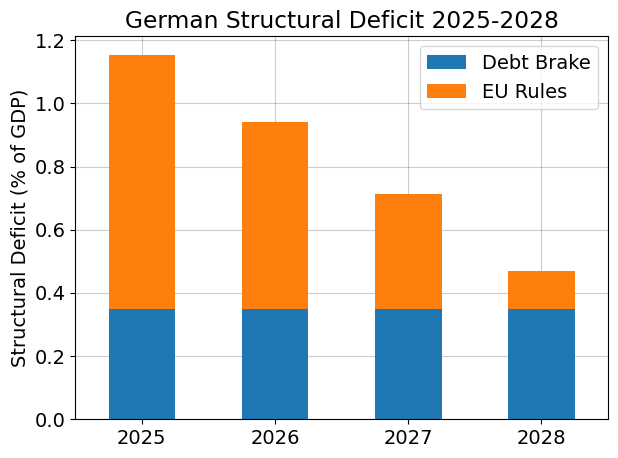

In [211]:
# Plot the additional fiscal space implied by Fiscal Rules
def plot_comp(results, rot=0, save=True):
    """
    Plot comparison of fiscal space implied by Fiscal Rules and Debt Break
    """

    # Plot
    fig, ax = plt.subplots()
    results[['sb_db','sb_diff']].plot(kind='bar', stacked=True, ax=ax)
    ax.set_xticklabels(results['y'], rotation=0)
    ax.set_ylabel('Structural Deficit (% of GDP)')
    ax.set_title(f'German Structural Deficit 2025-{results["y"].max()}')
    plt.xticks(rotation=rot)
    ax.legend(['Debt Brake', 'EU Rules'])
    ax.set_axisbelow(True)
    plt.tight_layout()
    if save:
        plt.savefig(f'structural_deficit_{results["y"].max()}.jpeg', dpi=300)
    plt.show()

plot_comp(results)

## Compare three consecutive 4-year adjustment periods

In [207]:
# Run model for two oncsecutive applications of the EU rules
cons_model = run_consecutive_dsa(
        'DEU',
        adjustment_start=2025, 
        initial_adjustment_period=4, 
        consecutive_adjustment_period=4, 
        number_of_adjustment_periods=3
)

# Save consecutive EU results
cons_eu_spb_target_1 = cons_model.spb[5]
cons_eu_spb_target_2 = cons_model.spb[9]
cons_eu_spb_target_3 = cons_model.spb_target
cons_eu_results = cons_model.df('sb', 'ob', 'ngdp').reset_index().loc[2:13]

{'main_adjustment': 0.2059999999998316, 'lower_spb': 0.6186999999998317, 'financial_stress': 0.24589999999983164, 'adverse_r_g': 0.6037999999998322, 'deficit_reduction': -0.4692000000001682, 'stochastic': -10.557274256260463, 'debt_safeguard': 0.7641999999998323, 'binding': 0.7641999999998323}
{'main_adjustment': -0.38770000000016824, 'lower_spb': -0.018100000000168814, 'financial_stress': -0.3488000000001681, 'adverse_r_g': 0.006199999999831063, 'deficit_reduction': -0.8801000000001695, 'stochastic': -0.15311081995143594, 'binding': 0.006199999999831007}
{'main_adjustment': -0.7359000000001688, 'lower_spb': -0.4094000000001681, 'financial_stress': -0.6963000000001687, 'adverse_r_g': -0.3443000000001686, 'deficit_reduction': -1.1310000000001696, 'stochastic': -0.6131863848114102, 'debt_safeguard': 0.1611999999998321, 'binding': 0.1611999999998321}


In [208]:
# Find SPB path consistent with a 0.35 percent structural deficit
calc_debt_break(cons_model)

# Save consecutive debt brake results
cons_db_spb_target_1 = cons_model.spb[5]
cons_db_spb_target_2 = cons_model.spb[9]
cons_db_spb_target_3 = cons_model.spb_target
cons_db_results = cons_model.df('sb', 'ob', 'ngdp').reset_index().loc[2:13]

In [209]:
# Compare consecutive results
cons_results = comp_results(cons_eu_results, cons_db_results)

print(f'SPB target 2028: EU {cons_eu_spb_target_1:.3f}, DB {cons_db_spb_target_1:.3f}')
print(f'SPB target 2032: EU {cons_eu_spb_target_2:.3f}, DB {cons_db_spb_target_2:.3f}')
print(f'SPB target 2036: EU {cons_eu_spb_target_3:.3f}, DB {cons_db_spb_target_3:.3f}')

2025-2028 Difference between strucutural deficit:
Average yearly difference as percent of GDP: 0.67
Total difference in billion EUR: 439.84

2025-2028 Difference between overall deficit:
Average yearly difference as percent of GDP: 0.60
Total difference in billion EUR: 398.09
SPB target 2028: EU 0.764, DB 0.848
SPB target 2032: EU 0.006, DB 0.885
SPB target 2036: EU 0.161, DB 0.885


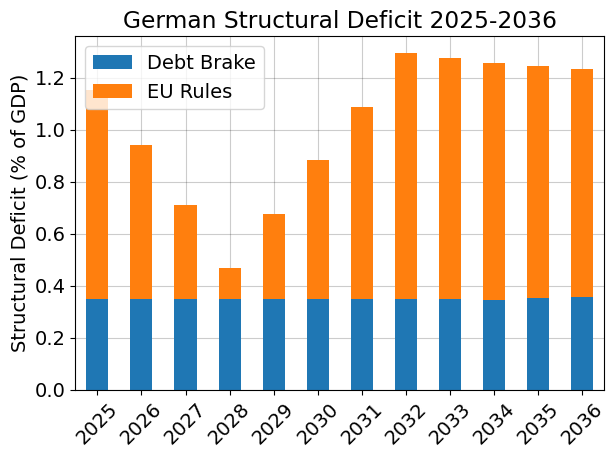

In [212]:
plot_comp(cons_results, rot=45)